Use this to connect Colab to a VSCode local session

In [3]:
import sys
from pathlib import Path

import numpy as np
import optuna
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount("/content/drive")
sys.path.append("./drive/MyDrive/source")
import mgc_classifier as mgc_classifier
import dataset_loader as datasets

from IPython.display import clear_output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

os.getcwd()


'/content'

In [42]:
datasets.PklDataset(0).categories


['arccos',
 'arccosh',
 'arcsin',
 'arcsinh',
 'arctan',
 'arctan2',
 'arctanh',
 'heaviside',
 'log',
 'log10',
 'log1p',
 'log2',
 'multiply',
 'sin',
 'sinh',
 'sqrt',
 'square',
 'tan',
 'tanh',
 'divide',
 'add',
 'subtract',
 'linear',
 'exponential',
 'cubic',
 'joint_normal',
 'step',
 'quadratic',
 'w_shaped',
 'spiral',
 'logarithmic',
 'fourth_root',
 'sin_four_pi',
 'sin_sixteen_pi',
 'two_parabolas',
 'circle',
 'ellipse',
 'diamond',
 'multiplicative_noise',
 'multimodal_independence']

In [6]:
class train_and_validate_static:
    """
    class that implements training the network and
    outputting validation metrics
    """

    def __init__(
        self,
        model,
        datapath,
        criterion,
        optimizer,
        lr,
        batch_size,
        minibatch_size,
        num_workers,
    ):

        # choose gpu or cpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # initialize the model
        self.model = model(
            out_channels=1, num_conv_layers=3, n_classes=40, img_size=128
        ).to(self.device)
        self.datapath = datapath
        self.optimizer = optimizer(self.model.parameters(), lr=lr)
        self.criterion = criterion.to(self.device)

        # hyperparameters
        self.batch_size = batch_size
        self.minibatch_size = minibatch_size
        self.num_workers = num_workers

        # initialize the logging variables
        self.training_loss = []
        self.validation_loss = []
        self.validation_accuracy = []
        self.class_accuracy = np.zeros(40)

        # training and validation dataloaders
        self.train_ratio = 0.99
        self.train_dataloader = None
        self.validation_dataloader = None

    def train(self, epochs=3):
        """
        train the network
        """

        # get the full dataset in the folder
        folder_dataset = datasets.PklDataset(self.datapath)
        print(len(folder_dataset))

        # split data into training and test

        train_data, validation_data = random_split(
            dataset=folder_dataset,
            lengths=[
                int(len(folder_dataset) * self.train_ratio),
                len(folder_dataset) - int(len(folder_dataset) * self.train_ratio),
            ],
        )
        print(len(train_data))

        # get the DataLoaders
        self.train_dataloader = DataLoader(
            dataset=train_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=datasets.PklDataset.collate_fn,
        )
        self.validation_dataloader = DataLoader(
            dataset=validation_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=datasets.PklDataset.collate_fn,
        )

        for epoch in range(10):
            # initialize the training loss averaging list
            temp_loss = []
            # iterate through the samples
            for i, batch_sample in enumerate(self.train_dataloader):
                minibatch = datasets.MinibatchDataset(data=batch_sample,)
                minibatch_dataloader = DataLoader(
                    dataset=minibatch,
                    batch_size=self.minibatch_size,
                    shuffle=True,
                    pin_memory=True,
                )
                for inputs, targets in minibatch_dataloader:

                    # send minibatch to gpu or cpu
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    # forward pass
                    predictions = self.model(inputs)

                    # loss
                    loss = self.criterion(predictions, targets)

                    # backward step
                    loss.backward()
                    self.optimizer.step()

                    temp_loss.append(loss.item())

                if i % 3 == 0:
                    clear_output(wait=True)
                    self.validate()
                    self.training_loss.append(np.mean(temp_loss))
                    if i % 10 == 0:
                        plt.plot(self.training_loss)
                        plt.plot(self.validation_loss)
                        plt.legend(["train", "val"])
                        plt.twinx().plot(self.validation_accuracy, "g")
                        plt.pause(0.0001)
                        plt.bar(
                            x=datasets.PklDataset(0).categories,
                            height=self.class_accuracy,
                        )
                        plt.xticks(rotation=90)
                        plt.pause(0.0001)
                    if len(self.validation_loss) > 10:
                        if self.validation_loss[-1] < self.validation_loss[-2]:
                            torch.save(
                                self.model.state_dict(),
                                Path("./drive/MyDrive/models/StaticMgcClassifier.pkl"),
                            )

    def validate(self):
        """
        validate the network predictions
        """
        with torch.no_grad():
            # initalize list to average the accuracy
            # and loss over the validation dataset
            loss_temp = []
            accuracy_temp = []
            prediction_class_sum = np.zeros(40)
            class_accuracy_temp = []
            for i, batch_sample in enumerate(self.validation_dataloader):
                minibatch = datasets.MinibatchDataset(data=batch_sample,)
                minibatch_dataloader = DataLoader(
                    dataset=minibatch,
                    batch_size=self.minibatch_size,
                    shuffle=True,
                    pin_memory=True,
                )
                for inputs, targets in minibatch_dataloader:

                    # send minibatch to gpu or cpu
                    inputs = inputs.to(self.device)
                    targets = targets

                    # run prediction on a subset of the data
                    predictions = self.model(inputs)
                    predictions = predictions.cpu()

                    # get validation loss
                    loss_temp.append(
                        self.criterion(predictions, targets).numpy().item()
                    )

                    # get validation accuracy
                    for j in range(predictions.shape[0]):
                        tgts = targets[j, :]
                        preds = predictions[j, :]
                        k = int(torch.sum(tgts))
                        prediction_topk = torch.topk(preds, k=k).indices
                        prediction_classes = torch.zeros_like(preds)
                        prediction_classes[prediction_topk] = 1.0
                        number_correct_classes = torch.sum(
                            torch.logical_and(tgts, prediction_classes)
                        )
                        accuracy_temp.append(
                            (number_correct_classes / k).numpy().item()
                        )
                        class_accuracy_temp.append(
                            torch.logical_and(tgts, prediction_classes).float().numpy()
                        )

            class_accuracy_temp = np.array(class_accuracy_temp)
            self.class_accuracy = (
                np.sum(class_accuracy_temp, axis=0) / class_accuracy_temp.shape[0]
            )
            self.validation_accuracy.append(np.mean(accuracy_temp))
            self.validation_loss.append(np.mean(loss_temp))


test_model = mgc_classifier.MgcNet

root_path = Path("./drive/MyDrive/data")
train_val_object = train_and_validate_static(
    model=mgc_classifier.MgcNet,
    datapath=root_path,
    criterion=nn.BCELoss(),
    optimizer=torch.optim.Adam,
    lr=1e-5,
    batch_size=5,  # just how much data can be loaded into memory at one time
    minibatch_size=1,  # what actually controls the batching size for training
    num_workers=2,
)

train_val_object.train()


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f82a67c54d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Note: For the adversarial, one of the parameters can be the number of classes

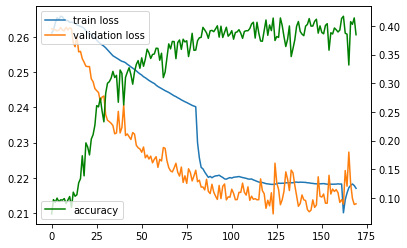

In [26]:
plt.plot(train_val_object.training_loss[:170])
plt.plot(train_val_object.validation_loss[:170])
ax1 = plt.gca()
ax1.legend(["train loss", "validation loss", "accuracy"], loc=2)

ax = plt.gca().twinx()
ax.plot(train_val_object.validation_accuracy[:170], "g")


ax.legend(["accuracy"], loc=3)


In [ ]:
def objective(trial):
    train_val_object = train_and_validate_static(
        model=mgc_classifier.MgcNet,
        datapath=root_path,
        criterion=nn.BCELoss(),
        optimizer=torch.optim.Adam,
        lr=1e-4,
        batch_size=5,  # just how much data can be loaded into memory at one time
        minibatch_size=1,  # what actually controls the batching size for training
        num_workers=2,
    )
    return (x - 2) ** 2


study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params


In [ ]:
while True:
    pass


In [ ]:
torch.tensor([[0, 2, 4, 6, 8, 10], [0, 1, 2, 3, 4, 5]])[0, :]
